In [72]:
cd(expanduser("/project/GHIST-2025/growth"))
Base.init_active_project()
pwd(), Base.active_project(), gethostname()

("/project/GHIST-2025/growth", "/project/GHIST-2025/growth/Project.toml", "folsomprisonblues.molgen.mpg.de")

In [73]:
using CSV
using DataFrames
using HistogramBinnings, StatsBase
using PyPlot
using HetDister, DemoPlots
using MariuxUtils, ProgressMeter, Distributed, Cached
using Serialization

In [74]:
df = CSV.read("GHIST_2025_growth.final.vcf.gz", DataFrame, comment = "##", drop = [:INFO])
first(df, 5)

Row,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,FORMAT,AFR_1,AFR_2,AFR_3,AFR_4,AFR_5,AFR_6,AFR_7,AFR_8,AFR_9,AFR_10,AFR_11,AFR_12,AFR_13,AFR_14,AFR_15,AFR_16,AFR_17,AFR_18,AFR_19,AFR_20,AFR_21,AFR_22,AFR_23,AFR_24,AFR_25,AFR_26,AFR_27,AFR_28,AFR_29,AFR_30,AFR_31,AFR_32
,String3,Int64,Int64,String1,String7,String1,String7,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3
1,2L,175,0,G,C,.,PASS,GT,0|1,0|1,1|1,0|1,1|1,0|1,1|0,1|0,1|0,1|0,1|1,1|0,1|0,0|0,0|1,0|1,1|0,0|1,0|1,1|0,0|0,1|0,1|1,1|1,0|0,0|1,1|1,1|0,1|0,0|1,0|0,0|1
2,2L,385,1,C,T,.,PASS,GT,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
3,2L,959,2,T,G,.,PASS,GT,0|1,0|1,1|1,0|1,1|1,0|1,1|0,1|0,1|0,1|0,1|1,1|0,1|0,0|0,0|1,0|1,1|0,0|1,0|1,1|0,0|0,1|0,1|1,1|1,0|0,0|1,1|1,1|0,1|0,0|1,0|0,0|1
4,2L,1050,3,A,T,.,PASS,GT,0|0,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
5,2L,1677,4,C,T,.,PASS,GT,0|1,0|1,1|1,0|1,1|1,0|1,1|0,1|0,1|0,1|0,1|1,1|0,1|0,0|0,0|1,0|1,1|0,0|1,0|1,1|0,0|0,1|0,1|1,1|1,0|0,0|1,1|1,1|0,1|0,0|1,0|0,0|1


In [75]:
@assert all(df.POS[2:end] .!= df.POS[1:end-1])

In [76]:
function getsegments(df, indv1, indv2, allele1, allele2)
    pos = [0]
    for r in eachrow(df)
        a1 = allele1 == 1 ? r[indv1][1] : r[indv1][3]
        a2 = allele2 == 1 ? r[indv2][1] : r[indv2][3]
        @assert a1 != '.' && a1 != '|'
        @assert a2 != '.' && a2 != '|'
        if a1 != a2
            push!(pos, r.POS)
        end
    end
    push!(pos, 108_990_206)
    ils = pos[2:end] .- pos[1:end-1]
end

getsegments (generic function with 1 method)

In [77]:
function aggsegs(df; nsamples=32)
    segs = Int[]
    for i in 1:(2nsamples-1)
        for j in i+1:2nsamples
            indv1 = "AFR_$((i+1)÷2)"
            indv2 = "AFR_$((j+1)÷2)"
            a1 = isodd(i) ? 1 : 2
            a2 = isodd(j) ? 1 : 2
            @assert indv1 != indv2 || a1 != a2
            ils = getsegments(df, indv1, indv2, a1, a2)
            if length(ils) == 0
                @error "No segments for $indv1($a1) and $indv2($a2), skipping."
                continue
            end
            append!(segs, ils)
        end
    end
    segs
end

aggsegs (generic function with 1 method)

In [78]:
function get_rho(chrs, path)
    rho = 0
    for chr in chrs
        genmap = CSV.read(path*chr*".txt", DataFrame)
        for i in 2:length(genmap[:, "Position(bp)"])
            locr = genmap[i, "Rate(cM/Mb)"]
            int = genmap[i, "Position(bp)"] - genmap[i-1, "Position(bp)"]
            rho += locr * int
        end
    end
    return rho / 108_990_206
end

get_rho (generic function with 1 method)

## aggregate

In [79]:
segments = aggsegs(df);

LoadError: InterruptException:

In [ ]:
# serialize("aggregate-segments-final", segments);
# segments = deserialize("aggregate-segments");

In [ ]:
segments = segments[segments .> 0];

In [ ]:
mu = 3.36e-8
L = sum(segments)

358004801107

In [ ]:
chrs = ["2L", "2R", "3L", "3R", "X"]
path = "comeron2012v2_maps/genetic_map_comeron2012v2_dm6_chr"
rho = inv(get_rho(chrs, path) * 1e6 * 1e2)

3.925916734729728e-9

In [ ]:
hagg = adapt_histogram(segments; nbins=1700, tailthr=2);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


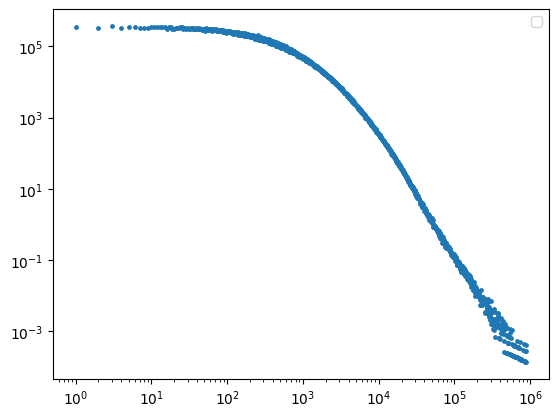

In [ ]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

x, y = xy(hagg)
ax.scatter(x, y; s = 6)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

In [ ]:
fop = FitOptions(L, mu, rho; maxnts=5, iterations=30000, time_limit=120, g_tol=1e-5)
naive = pre_fit!(fop, hagg, 6; require_convergence=false)

6-element Vector{FitResult}:
 Fit stationary (binned 1700) L-BFGS ● [1.8e+11, 8376.3] logL -1651775.671 | evidence -1651802.117
 Fit 2 epochs (binned 1700) L-BFGS ● [2.0e+11, 7330.7, 1705.1, 27817.8] logL -379574.348 | evidence -379627.338
 Fit 3 epochs (binned 1700) L-BFGS ● [2.0e+11, 10845.3, 29217.0, 6515.7, 2810.6, 19148.8] logL -167078.831 | evidence -167159.010
 Fit 4 epochs (binned 1700) L-BFGS ● [2.0e+11, 10682.3, 27350.1, 6449.8, 2241.4, 13102.2, 1129.9, 25359.4] logL -165998.893 | evidence -166102.823
 Fit 5 epochs (binned 1700) L-BFGS ● [2.0e+11, 11635.0, 25973.2, 8588.7, 20386.7, 6352.0, 2416.2, 11453.7, 1349.4, 24647.2] logL -165775.641 | evidence -165900.277
 Fit 6 epochs (binned 1700) L-BFGS ● [2.0e+11, 10.0, 38508.1, 100000000.0, 57480.4, 9028.5, 21167.9, 6350.0, 2423.8, 11389.6, 1359.0, 24615.3] logL -165717.692 | evidence -165848.444

In [ ]:
cutoff = 1e-5
o = findfirst(map(i->HetDister.fraction(mu,rho,i),1:30) .< cutoff)

7

In [ ]:
job = (; hagg.edges, hagg.weights, L, mu, rho)

(edges = (LogEdgeVector{Int64}: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

In [ ]:
fem = FlexElasticManager(threads = 64, runtime = "3h", memory = "60G") # 72 min

FlexElasticManager: AKI-Sun-2037 active: 0

In [ ]:
MariuxUtils.@everywhere fem begin

    using HetDister, StatsBase, Cached

    function fit(job)
        h = Histogram(job.edges)
        h.weights .= job.weights
        fop = FitOptions(job.L, job.mu, job.rho; order = 10, ndt = 1700, 
            maxnts=5, iterations=30000, time_limit=120, g_tol=1e-5
        )
        fit = demoinfer(h, 4:7, fop; iters = 30, corcut = 0)
        return fit
    end

end # everywhere

In [ ]:
addprocs(fem, MXQ, 1)

FlexElasticManager: AKI-Sun-2037 active: 0  MXQgroup (3h): no active jobs

In [ ]:
waituntilactive(fem)

FlexElasticManager: AKI-Sun-2037 active: 1  MXQgroup (3h): inq:0 run:1 fin:0

In [ ]:
results = pmap(fit, [job]);

In [ ]:
# serialize("results-final", results)

In [ ]:
rmprocs(fem)

FlexElasticManager: AKI-Sun-2037 active: 0, terminated: 1  MXQgroup (3h): inq:0 run:1 fin:0

In [ ]:
results[1].fits

4-element Vector{FitResult}:
 Fit 4 epochs (binned 1700) L-BFGS ● [2.0e+11, 9654.1, 27321.0, 5869.5, 2357.4, 7127.8, 1402.0, 23278.0] logL -175432.773 | evidence -175536.665
 Fit 5 epochs (binned 1700) L-BFGS ● [2.0e+11, 9621.2, 26331.0, 5855.3, 2923.2, 6683.9, 1377.8, 21202.8, 166.2, 38519.9] logL -175363.429 | evidence -175489.376
 Fit 6 epochs (binned 1700) L-BFGS ● [2.0e+11, 10249.9, 23965.0, 6594.0, 7052.3, 5317.5, 6744.0, 6352.2, 1437.1, 20436.1, 203.2, 35837.7] logL -175257.359 | evidence -175403.574
 Fit 7 epochs (binned 1700) L-BFGS ○ [2.0e+11, 10254.4, 27402.8, 6553.1, 16.9, 82.1, 10068.3, 6268.7, 1021.2, 17010.1, 618.3, 23112.6, 115.0, 44158.3] logL -175249.982 | evidence -175410.571

In [ ]:
f = compare_models(results[1].fits)

Fit 6 epochs (binned 1700) L-BFGS ● [2.0e+11, 10249.9, 23965.0, 6594.0, 7052.3, 5317.5, 6744.0, 6352.2, 1437.1, 20436.1, 203.2, 35837.7] logL -175257.359 | evidence -175403.574

In [ ]:
results[1].chains[3]

9-element Vector{Any}:
 Fit 6 epochs (binned 1700) L-BFGS ● [2.0e+11, 10531.6, 24718.5, 6678.2, 7105.6, 5160.5, 6683.0, 6204.8, 1531.9, 21093.1, 328.5, 34323.7] logL -175671.437 | evidence -175817.679
 Fit 6 epochs (binned 1700) L-BFGS ● [2.0e+11, 10232.3, 27198.3, 6519.2, 13.3, 66.0, 9980.0, 6292.8, 1457.3, 20719.3, 194.6, 37748.6] logL -175254.957 | evidence -175403.416
 Fit 6 epochs (binned 1700) L-BFGS ● [2.0e+11, 10243.3, 24319.7, 6569.4, 6250.4, 5224.3, 7006.2, 6351.7, 1436.1, 20507.2, 200.6, 35970.9] logL -175257.478 | evidence -175403.598
 Fit 6 epochs (binned 1700) L-BFGS ● [2.0e+11, 10249.2, 23945.3, 6592.8, 7089.2, 5322.0, 6714.1, 6354.6, 1435.6, 20442.6, 203.5, 35806.2] logL -175257.401 | evidence -175403.633
 Fit 6 epochs (binned 1700) L-BFGS ● [2.0e+11, 10250.4, 23932.9, 6596.2, 7126.2, 5325.0, 6717.8, 6352.9, 1436.6, 20433.5, 203.5, 35813.1] logL -175256.871 | evidence -175403.101
 Fit 6 epochs (binned 1700) L-BFGS ● [2.0e+11, 10250.1, 23963.1, 6594.3, 7058.0, 5318.0, 67

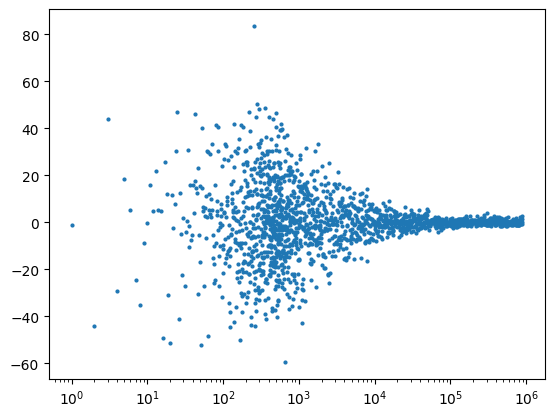

In [ ]:
_, ax = subplots(1,1)
# resid = compute_residuals(hagg, mu, rho, get_para(naive[7]), order = 20, ndt = 1700, naive=true)
wth = results[1].yth[3] .* diff(hagg.edges[1])
# wth = HetDister.integral_ws(hagg.edges[1], mu, get_para(naive[6]))
resid = (hagg.weights .- wth) ./ sqrt.(wth)
x, y = xy(hagg)
scatter(x, resid; s=4)
xscale("log")
# ylim(-0.3,0.3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


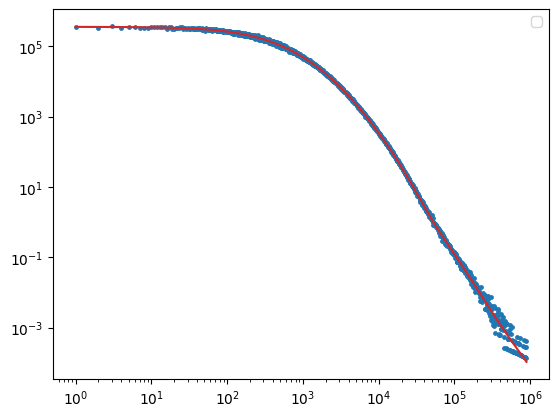

In [81]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

x, y = xy(hagg)
ax.scatter(x, y; s = 6)
ax.plot(x, results[1].yth[3], color="tab:red")

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

In [89]:
para = get_para(results[1].fits[3])
para[end] / para[end-2], sum(para[end-1:2:end-1])

(1.753640735037594, 203.17267614252222)

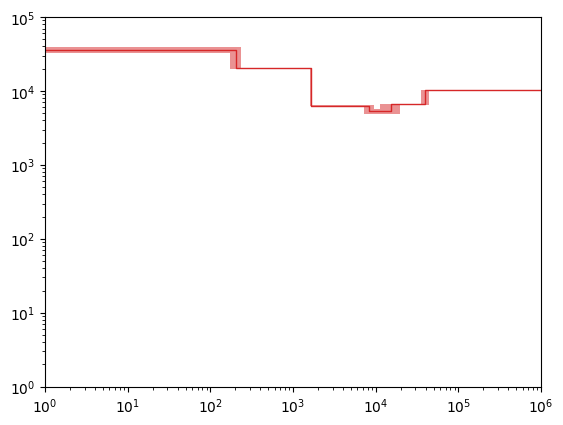

(1, 100000.0)

In [88]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

plot_demography(results[1].fits[3], ax; g = 1, rho)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1, 1e6)
ax.set_ylim(1, 1e5)

## all pairs

In [19]:
segments = getsegments(df, :sample_1, :sample_3, 2, 2);
h = adapt_histogram(segments; nbins = 800)

Histogram{Int64, 1, Tuple{LogEdgeVector{Int64}}}
edges:
  LogEdgeVector{Int64}: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 20

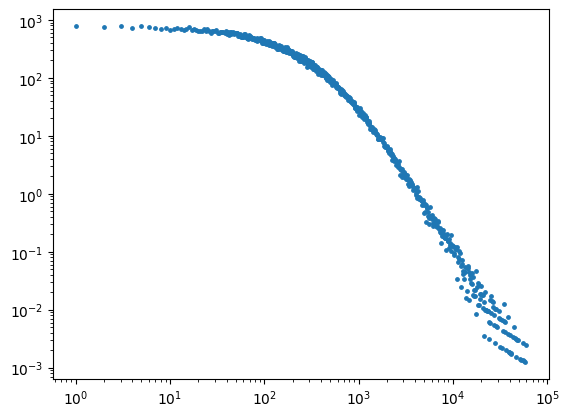

In [20]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

x, y = xy(h)
ax.scatter(x, y; s = 6)

ax.set_xscale("log")
ax.set_yscale("log")

In [6]:
histograms = makepairs(df);

In [4]:
# serialize("histograms", histograms)
histograms = deserialize("histograms");

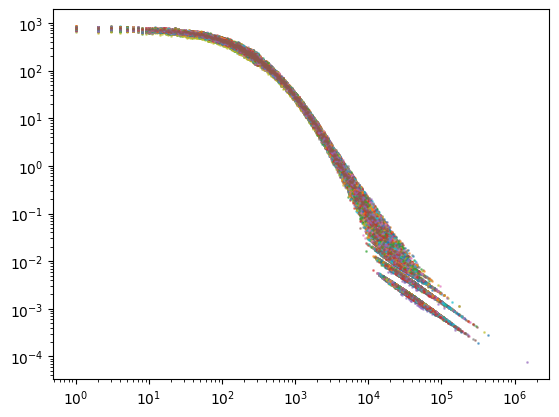

In [9]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

for h in histograms
    x, y = xy(h)
    ax.scatter(x, y; s = 1, alpha = 0.5)
end

ax.set_xscale("log")
ax.set_yscale("log")

In [5]:
mu = 1.4e-8
rho = 1.5e-8

1.5e-8

In [6]:
jobs = map(histograms) do h
    (; h.edges, h.weights, mu, rho, L = 100_000_000)
end;

In [7]:
cache = SQLiteCache("/project/GHIST-2025/bottleneck-challenge/pairs.cache")

SQLiteCache at /project/GHIST-2025/bottleneck-challenge/pairs.cache

In [8]:
length(jobs)

946

In [46]:
fem = FlexElasticManager(threads = 8, runtime = "3h", memory = "60G") # 31m

FlexElasticManager: HLO-Wed-1211 active: 0

In [47]:
MariuxUtils.@everywhere fem begin

    using HetDister, StatsBase, Cached

    function fit_pair(job)
        h = Histogram(job.edges)
        h.weights .= job.weights
        fop = FitOptions(job.L, job.mu, job.rho; order = 20, maxnts = 8)
        res = demoinfer(h, 2, fop; iters = 10, corcut = 0)
        opt = (;
            iterations = 600,
            allow_f_increases=true,
            time_limit = 7000,
            g_tol = 5e-8,
            show_warnings = false
        )
        fop.opt = HetDister.Optim.Options(;opt...)
        HetDister.setnaive!(fop, false)
        HetDister.setnepochs!(fop, 2)
        init = get_para(res.f)
        HetDister.setinit!(fop, init)
        mle = HetDister.fit_model_epochs!(fop, h)
        # yth = deepcopy(res.yth)
        final = get_para(mle)
        conv = mle.converged
        return (; 
            final,
            conv,
            res.chain,
            res.corrections,
            res.yth,
            res.deltas
        )
    end

end # everywhere

In [48]:
addprocs(fem, MXQ, 500)

FlexElasticManager: HLO-Wed-1211 active: 0  MXQgroup (3h): no active jobs

In [ ]:
waituntilactive(fem)

FlexElasticManager: HLO-Wed-1211 active: 404  MXQgroup (3h): inq:96 run:404 fin:0

Progress:  75%|███████▄  |  ETA: 0:28:51

In [74]:
@async results = pcmap(fit_pair, cache, jobs);

In [90]:
summary(cache)

"SQLiteCache at /project/GHIST-2025/bottleneck-challenge/pairs.cache: 925 items in memory, 924 items on disk, 60.430 MiB on disk"

In [94]:
fem

FlexElasticManager: HLO-Wed-1211 active: 0, terminated: 500  MXQgroup (3h): inq:0 run:0 fin:333 fail:167

In [92]:
rmprocs(fem)

FlexElasticManager: HLO-Wed-1211 active: 0, terminated: 500  MXQgroup (3h): inq:0 run:96 fin:318 fail:86

In [ ]:
Cached.loadall!(cache)
results = values(cache.loaded);

In [121]:
meanpara = zeros(Float64, 4)
count = 0
for res in results
    try
        if res.conv == true
            meanpara .+= res.final
            count += 1
        end
    catch
        if res.mle.converged == true
            meanpara .+= get_para(res.mle)
            count += 1
        end
    end
end
meanpara ./= count
count

872

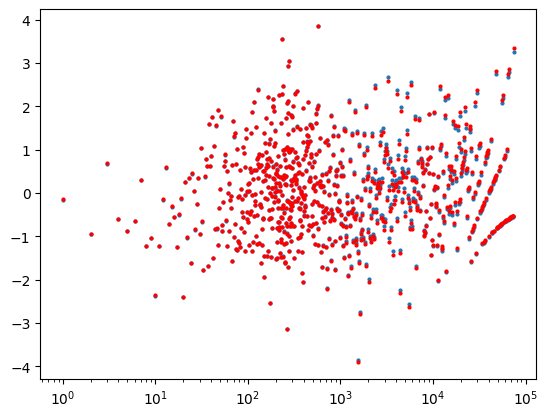

Worker 2 terminated.
Unhandled Task ERROR: EOFError: read end of file
Stacktrace:
 [1] (::Base.var"#wait_locked#unsafe_read##0")(s::Sockets.TCPSocket, buf::IOBuffer, nb::Int64)
   @ Base ./stream.jl:980
 [2] unsafe_read(s::Sockets.TCPSocket, p::Ptr{UInt8}, nb::UInt64)
   @ Base ./stream.jl:988
 [3] unsafe_read
   @ ./io.jl:890 [inlined]
 [4] unsafe_read(s::Sockets.TCPSocket, p::Base.RefValue{NTuple{4, Int64}}, n::Int64)
   @ Base ./io.jl:889
 [5] read!
   @ ./io.jl:894 [inlined]
 [6] deserialize_hdr_raw
   @ ~/.julia/juliaup/julia-1.12.1+0.x64.linux.gnu/share/julia/stdlib/v1.12/Distributed/src/messages.jl:167 [inlined]
 [7] message_handler_loop(r_stream::Sockets.TCPSocket, w_stream::Sockets.TCPSocket, incoming::Bool)
   @ Distributed ~/.julia/juliaup/julia-1.12.1+0.x64.linux.gnu/share/julia/stdlib/v1.12/Distributed/src/process_messages.jl:172
 [8] process_tcp_streams(r_stream::Sockets.TCPSocket, w_stream::Sockets.TCPSocket, incoming::Bool)
   @ Distributed ~/.julia/juliaup/julia-1.12.1

In [ ]:
_, ax = subplots(1,1)
for res in results
    wth = res.yth .* diff(histograms[1].edges[1])
    resid = (histograms[1].weights .- wth) ./ sqrt.(wth)
    # resid = compute_residuals(histograms[1], mu, rho, get_para(results[1].mle), order = 20)
    x, y = xy(histograms[1])
    scatter(x[1:end], resid[1:end]; s=4)
xscale("log")

In [122]:
meanpara[end] / meanpara[2], meanpara[end-1]

(0.45624968319126147, 8034.834238397046)

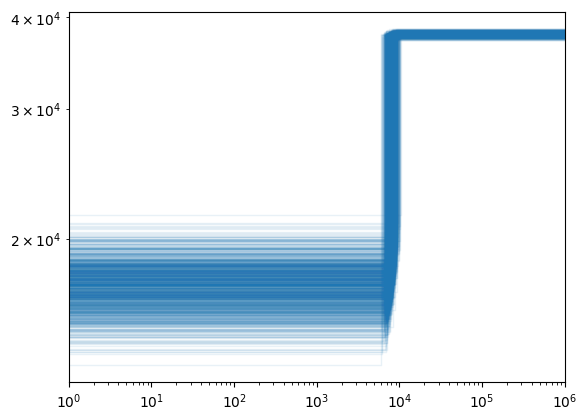

(1, 1.0e6)

In [105]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

# results = deserialize("results-pairs");

for res in results
    f = nothing
    try 
        f = res.final
    catch
        f = get_para(res.mle)
    end
    plot_demography(f, [1,1,1,1], ax; g = 1, rho, alpha = 0.1, alphapatch=0.00, color = "tab:blue")
end
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1, 1e6)

In [123]:
allts = Float64[]
for res in results
    try
        if res.conv == true
            push!(allts, res.final[end-1])
        end
    catch
        if res.mle.converged == true
            push!(allts, get_para(res.mle)[end-1])
        end
    end
end

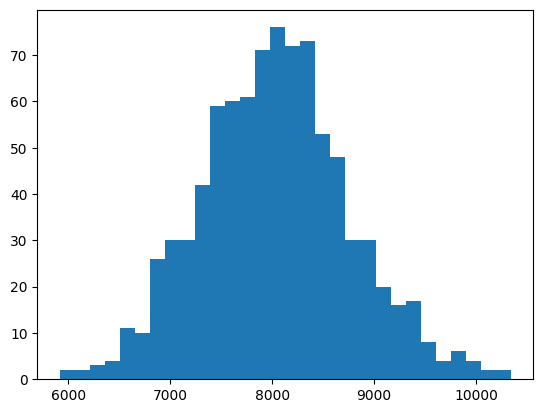

([2.0, 2.0, 3.0, 4.0, 11.0, 10.0, 26.0, 30.0, 30.0, 42.0  …  30.0, 20.0, 16.0, 17.0, 8.0, 4.0, 6.0, 4.0, 2.0, 2.0], [5919.685002556233, 6067.026101690875, 6214.367200825517, 6361.70829996016, 6509.049399094802, 6656.390498229444, 6803.731597364087, 6951.072696498729, 7098.413795633372, 7245.754894768013  …  9013.848084383722, 9161.189183518363, 9308.530282653006, 9455.871381787649, 9603.212480922291, 9750.553580056934, 9897.894679191577, 10045.23577832622, 10192.57687746086, 10339.917976595503], (PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccf3d0>, PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccf220>, PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccf7f0>, PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccfa30>, PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccfc10>, PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccfdf0>, PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccffd0>, PyObject <matplotlib.patches.Rectang

In [124]:
hist(allts, bins=30)